In [1]:
# Data Loading Section
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Load data
data_folder = os.path.join(os.path.dirname(os.getcwd()), 'data')
data_train = pd.read_csv(os.path.join(data_folder, 'train.csv'))
print(f"Dataset shape: {data_train.shape}")
data_train.head()

Dataset shape: (9543, 2)


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [2]:
# Setup Section
# Change to parent directory to import modules
print("Current working directory:", os.getcwd())
os.chdir(os.path.dirname(os.getcwd()))
print("Changed working directory to:", os.getcwd())

Current working directory: /Users/joanaesteves/Desktop/MDSAA-DS/S2/T4/TM/TM_Project/Notebooks
Changed working directory to: /Users/joanaesteves/Desktop/MDSAA-DS/S2/T4/TM/TM_Project


In [4]:
#from src.embedding import TextEmbedder
from src.preprocessing import Preprocessing

# Initialize preprocessing
preprocessor = Preprocessing(lemmatize=True, stem=False)

print("Modules imported successfully")

Modules imported successfully


In [7]:
# Data Preparation Section
# Use a subset for testing (embedding can be computationally intensive)
subset_size = 500
sample_data = data_train.sample(n=subset_size, random_state=42)

# Get raw texts
raw_texts = sample_data['text'].tolist()
labels = sample_data['label'].tolist()

print(f"Sample size: {len(raw_texts)}")
print(f"Label distribution:")
print(pd.Series(labels).value_counts())

# Show sample texts
print("\nSample texts:")
for i, text in enumerate(raw_texts[:3], 1):
    print(f"{i}. {text[:100]}...")

Sample size: 500
Label distribution:
2    306
1    117
0     77
Name: count, dtype: int64

Sample texts:
1. When staffers in WeWork's New York City headquarters received a calendar invite for a mandatory meet...
2. ADMA Biologics down 9% premarket after pricing equity offering...
3. Illegal Tender podcast: What it was like to befriend convicted socialite scammer Anna Delvey...


In [8]:
# Preprocess texts for word2vec and BoW (transformers work better with raw text)
print("Preprocessing texts...")
processed_tokens = preprocessor.preprocess(raw_texts)
processed_texts = [' '.join(tokens) for tokens in processed_tokens]

print(f"\nProcessing complete. Sample processed texts:")
for i, text in enumerate(processed_texts[:3], 1):
    print(f"{i}. {text[:100]}...")

Preprocessing texts...
ASCII cleaned text: when staffers in wework new york city headquarters received a calendar invite for a mandatory meeting with a note  URL
ASCII cleaned text: adma biologics down    premarket after pricing equity offering
ASCII cleaned text: illegal tender podcast  what it was like to befriend convicted socialite scammer anna delvey
ASCII cleaned text: the splunk datato everything platform brings speed and scale to mclaren
ASCII cleaned text: opec share of indian oil imports in october hits lowest since     
ASCII cleaned text:  m   macy to test new concept URL
ASCII cleaned text: china xi visits hospital in beijing
ASCII cleaned text:  mtsc   mts systems declares COST dividend URL
ASCII cleaned text: tesla cybertruck hits        orders just days after botched launch
ASCII cleaned text: lhc
ASCII cleaned text: billionaire investor bill ackman trims stake in chipotle  but is still betting big on burritos with    stake
ASCII cleaned text: should you be impressed by

In [6]:
# Embedding Configurations Section
# Define embedding configurations to test
embedding_configs = [
    {
        'name': 'Word2Vec (Skip-gram)',
        'method': 'word2vec',
        'vector_size': 100,
        'window': 5,
        'min_count': 2,
        'sg': 1
    },
    {
        'name': 'Word2Vec (CBOW)',
        'method': 'word2vec',
        'vector_size': 100,
        'window': 5,
        'min_count': 2,
        'sg': 0
    },
    {
        'name': 'BoW (Unigrams)',
        'method': 'bow',
        'max_features': 1000,
        'ngram_range': (1, 1),
        'stop_words': 'english'
    },
    {
        'name': 'BoW (Unigrams + Bigrams)',
        'method': 'bow',
        'max_features': 1000,
        'ngram_range': (1, 2),
        'stop_words': 'english'
    },
    {
        'name': 'SentenceTransformer (MiniLM)',
        'method': 'transformer',
        'model_name': 'sentence-transformers/all-MiniLM-L6-v2'
    },
    {
        'name': 'SentenceTransformer (MPNet)',
        'method': 'transformer',
        'model_name': 'sentence-transformers/all-mpnet-base-v2'
    }
]

print(f"Configured {len(embedding_configs)} embedding methods:")
for config in embedding_configs:
    print(f"  • {config['name']}")

Configured 6 embedding methods:
  • Word2Vec (Skip-gram)
  • Word2Vec (CBOW)
  • BoW (Unigrams)
  • BoW (Unigrams + Bigrams)
  • SentenceTransformer (MiniLM)
  • SentenceTransformer (MPNet)


In [7]:
# Performance Comparison Section
# Test all embedding methods
embedding_results = []
embeddings_dict = {}

for config in embedding_configs:
    print(f"\n Testing {config['name']}...")
    
    # Extract config parameters
    name = config.pop('name')
    method = config['method']
    
    try:
        # Initialize embedder
        embedder = TextEmbedder(**config)
        
        # Choose appropriate text input
        if method in ['word2vec', 'bow']:
            input_texts = processed_texts
        else:  # transformer methods work better with raw text
            input_texts = raw_texts
        
        # Time the fitting process
        start_time = time.time()
        embedder.fit(input_texts)
        fit_time = time.time() - start_time
        
        # Time the transformation process
        start_time = time.time()
        embeddings = embedder.transform(input_texts)
        transform_time = time.time() - start_time
        
        # Store embeddings for later analysis
        embeddings_dict[name] = embeddings
        
        # Calculate metrics
        total_time = fit_time + transform_time
        embedding_dim = embeddings.shape[1]
        sparsity = np.mean(embeddings == 0) * 100  # Percentage of zero values
        
        embedding_results.append({
            'Method': name,
            'Embedding Dimension': embedding_dim,
            'Fit Time (s)': fit_time,
            'Transform Time (s)': transform_time,
            'Total Time (s)': total_time,
            'Texts per Second': len(input_texts) / total_time,
            'Sparsity (%)': sparsity,
            'Memory Usage (MB)': embeddings.nbytes / (1024**2)
        })
        
        print(f"    Success - Dimension: {embedding_dim}, Time: {total_time:.2f}s")
        
    except Exception as e:
        print(f"    Failed: {str(e)}")
        embedding_results.append({
            'Method': name,
            'Error': str(e)
        })

# Create results DataFrame
results_df = pd.DataFrame(embedding_results)
print("\n📊 Embedding Performance Results:")
print(results_df.round(3))


 Testing Word2Vec (Skip-gram)...
    Success - Dimension: 100, Time: 0.06s

 Testing Word2Vec (CBOW)...
    Success - Dimension: 100, Time: 0.03s

 Testing BoW (Unigrams)...
    Success - Dimension: 1000, Time: 0.01s

 Testing BoW (Unigrams + Bigrams)...
    Success - Dimension: 1000, Time: 0.01s

 Testing SentenceTransformer (MiniLM)...
    Success - Dimension: 384, Time: 5.41s

 Testing SentenceTransformer (MPNet)...
    Success - Dimension: 768, Time: 8.31s

📊 Embedding Performance Results:
                         Method  Embedding Dimension  Fit Time (s)  \
0          Word2Vec (Skip-gram)                  100         0.050   
1               Word2Vec (CBOW)                  100         0.023   
2                BoW (Unigrams)                 1000         0.012   
3      BoW (Unigrams + Bigrams)                 1000         0.009   
4  SentenceTransformer (MiniLM)                  384         3.498   
5   SentenceTransformer (MPNet)                  768         2.711   

   Transf

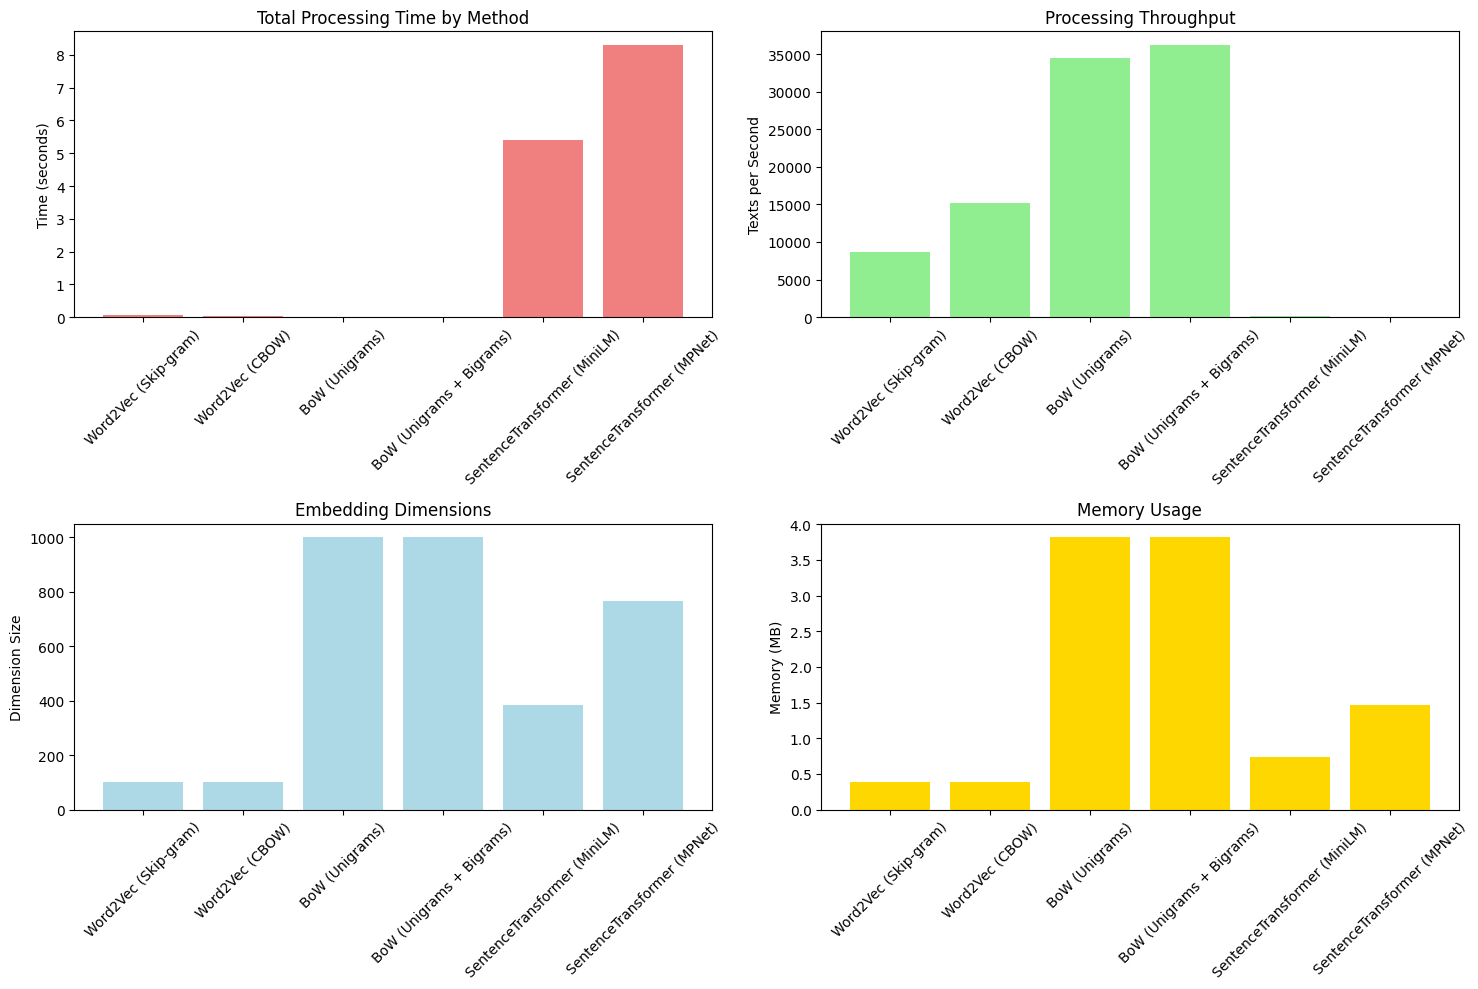

In [8]:
# Performance Visualization Section
# Filter successful results for visualization
successful_results = results_df.dropna(subset=['Embedding Dimension'])

if len(successful_results) > 0:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Processing time comparison
    ax1.bar(successful_results['Method'], successful_results['Total Time (s)'], color='lightcoral')
    ax1.set_title('Total Processing Time by Method')
    ax1.set_ylabel('Time (seconds)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Throughput comparison
    ax2.bar(successful_results['Method'], successful_results['Texts per Second'], color='lightgreen')
    ax2.set_title('Processing Throughput')
    ax2.set_ylabel('Texts per Second')
    ax2.tick_params(axis='x', rotation=45)
    
    # Embedding dimension
    ax3.bar(successful_results['Method'], successful_results['Embedding Dimension'], color='lightblue')
    ax3.set_title('Embedding Dimensions')
    ax3.set_ylabel('Dimension Size')
    ax3.tick_params(axis='x', rotation=45)
    
    # Memory usage
    ax4.bar(successful_results['Method'], successful_results['Memory Usage (MB)'], color='gold')
    ax4.set_title('Memory Usage')
    ax4.set_ylabel('Memory (MB)')
    ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("No successful embeddings to visualize")

In [9]:
# Embedding Quality Analysis Section
# Analyze embedding quality through similarity analysis
def analyze_embedding_quality(embeddings, method_name, texts, labels, n_similar=5):
    """Analyze embedding quality through similarity and clustering"""
    print(f"\n Quality Analysis for {method_name}:")
    
    # Calculate pairwise similarities
    similarities = cosine_similarity(embeddings)
    
    # Find most similar text pairs
    print(f"\n🔍 Most Similar Text Pairs:")
    np.fill_diagonal(similarities, -1)  # Exclude self-similarity
    
    for i in range(min(3, len(texts))):
        most_similar_idx = np.argmax(similarities[i])
        similarity_score = similarities[i, most_similar_idx]
        
        print(f"\nPair {i+1} (similarity: {similarity_score:.3f}):")
        print(f"  Text A: {texts[i][:80]}...")
        print(f"  Text B: {texts[most_similar_idx][:80]}...")
        print(f"  Labels: {labels[i]} vs {labels[most_similar_idx]}")
    
    # Calculate statistics
    mean_similarity = np.mean(similarities[similarities > -1])
    std_similarity = np.std(similarities[similarities > -1])
    
    print(f"\n📊 Similarity Statistics:")
    print(f"  Mean similarity: {mean_similarity:.3f}")
    print(f"  Std similarity: {std_similarity:.3f}")
    print(f"  Embedding shape: {embeddings.shape}")
    
    return {
        'mean_similarity': mean_similarity,
        'std_similarity': std_similarity,
        'embedding_shape': embeddings.shape
    }

# Analyze quality for each successful embedding method
quality_results = {}
for method_name, embeddings in embeddings_dict.items():
    if method_name in successful_results['Method'].values:
        quality_results[method_name] = analyze_embedding_quality(
            embeddings, method_name, raw_texts, labels
        )


 Quality Analysis for Word2Vec (Skip-gram):

🔍 Most Similar Text Pairs:

Pair 1 (similarity: 0.986):
  Text A: When staffers in WeWork's New York City headquarters received a calendar invite ...
  Text B: $M - Macy's to test new concept https://t.co/GDPbKYfu65...
  Labels: 2 vs 2

Pair 2 (similarity: 0.811):
  Text A: ADMA Biologics down 9% premarket after pricing equity offering...
  Text B: Stocks making the biggest moves in the premarket: Uber, Canada Goose, Hanesbrand...
  Labels: 0 vs 2

Pair 3 (similarity: 0.755):
  Text A: Illegal Tender podcast: What it was like to befriend convicted socialite scammer...
  Text B: Yeah $DIS  12/20 $150C @1.16 entry got 5. Reason is look at the inside day hamme...
  Labels: 2 vs 1

📊 Similarity Statistics:
  Mean similarity: 0.852
  Std similarity: 0.192
  Embedding shape: (500, 100)

 Quality Analysis for Word2Vec (CBOW):

🔍 Most Similar Text Pairs:

Pair 1 (similarity: 0.739):
  Text A: When staffers in WeWork's New York City headquarters rec


 Visualizing Word2Vec (Skip-gram)...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


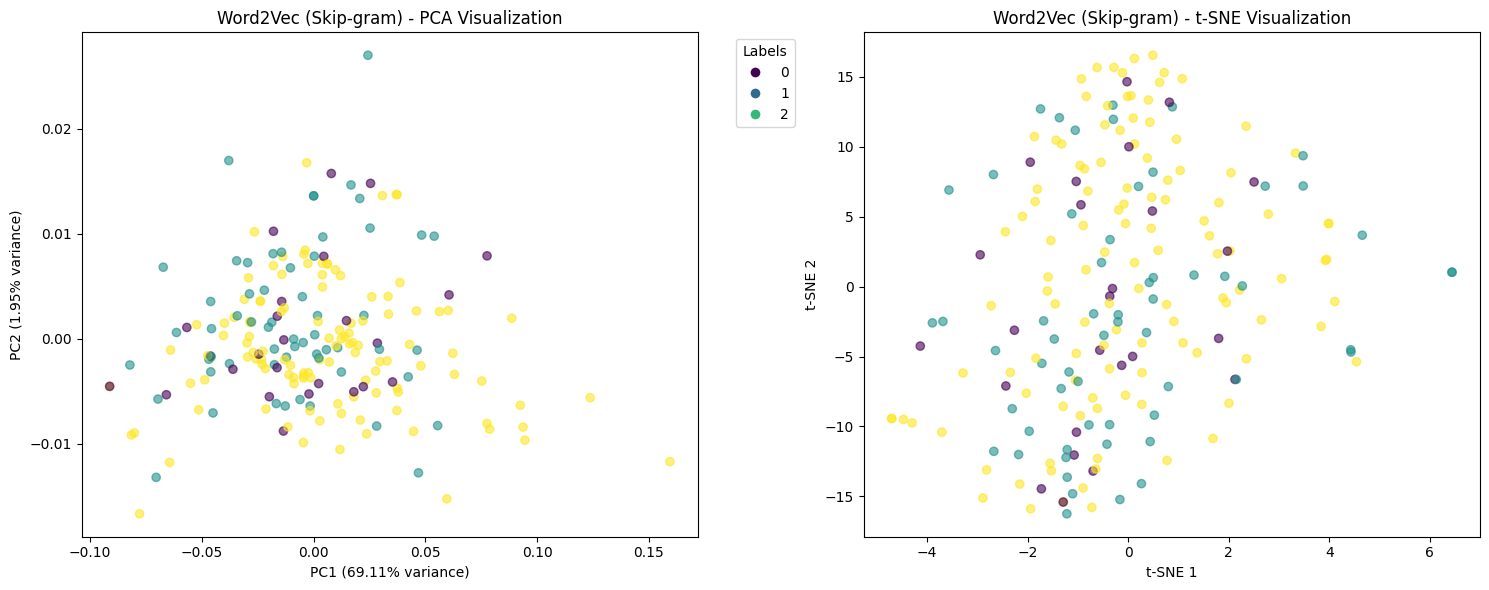


 Visualizing Word2Vec (CBOW)...


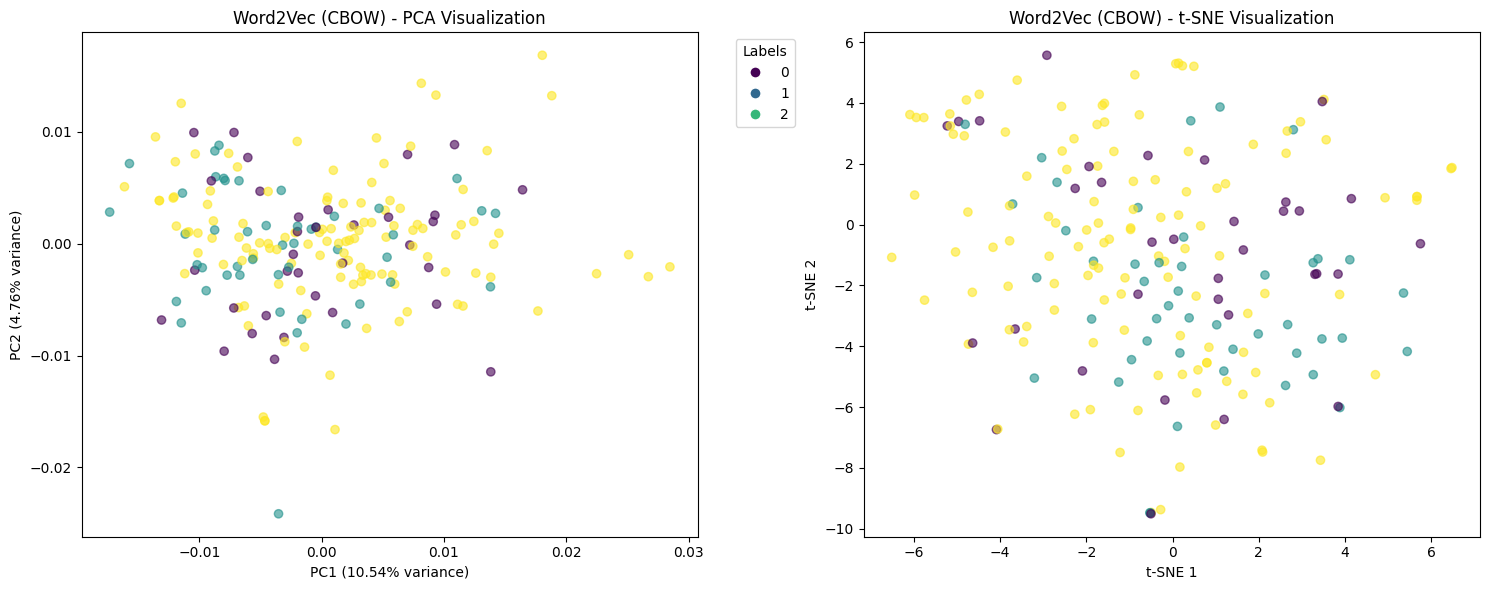


 Visualizing BoW (Unigrams)...


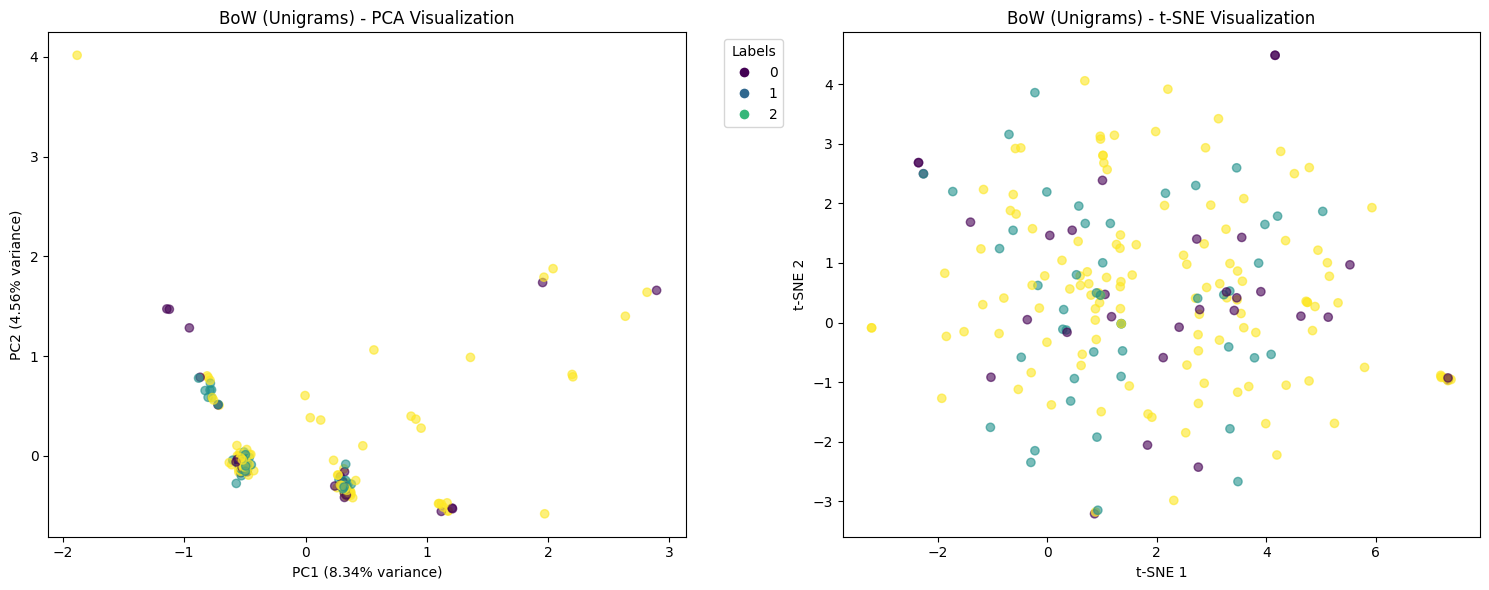

In [10]:
# Dimensionality Reduction Visualization Section
# Visualize embeddings using PCA and t-SNE
def visualize_embeddings(embeddings, labels, method_name, max_samples=200):
    """Visualize embeddings using PCA and t-SNE"""
    
    # Sample data if too large
    if len(embeddings) > max_samples:
        indices = np.random.choice(len(embeddings), max_samples, replace=False)
        embeddings = embeddings[indices]
        labels = [labels[i] for i in indices]
    
    # Convert labels to numeric for coloring
    unique_labels = list(set(labels))
    label_colors = [unique_labels.index(label) for label in labels]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # PCA visualization
    pca = PCA(n_components=2, random_state=42)
    pca_embeddings = pca.fit_transform(embeddings)
    
    scatter1 = ax1.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], 
                          c=label_colors, cmap='viridis', alpha=0.6)
    ax1.set_title(f'{method_name} - PCA Visualization')
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    
    # t-SNE visualization (only if not too many dimensions and samples)
    if embeddings.shape[1] <= 1000 and len(embeddings) <= 500:
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings)-1))
        tsne_embeddings = tsne.fit_transform(embeddings)
        
        scatter2 = ax2.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], 
                              c=label_colors, cmap='viridis', alpha=0.6)
        ax2.set_title(f'{method_name} - t-SNE Visualization')
        ax2.set_xlabel('t-SNE 1')
        ax2.set_ylabel('t-SNE 2')
    else:
        ax2.text(0.5, 0.5, 't-SNE skipped\n(too many dimensions\nor samples)', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
        ax2.set_title(f'{method_name} - t-SNE (Skipped)')
    
    # Add legend
    if len(unique_labels) <= 10:  # Only show legend if not too many labels
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                     markerfacecolor=plt.cm.viridis(i/len(unique_labels)), 
                                     markersize=8, label=str(label)) 
                          for i, label in enumerate(unique_labels)]
        ax1.legend(handles=legend_elements, title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Visualize embeddings for each method
for method_name, embeddings in list(embeddings_dict.items())[:3]:  # Limit to first 3 for brevity
    print(f"\n Visualizing {method_name}...")
    visualize_embeddings(embeddings, labels, method_name)

In [11]:
# Semantic Similarity Testing Section
# Test semantic similarity with known similar/dissimilar pairs
test_pairs = [
    ("This movie is amazing and wonderful", "Great film, loved every minute", "Similar sentiment"),
    ("Terrible movie, waste of time", "Awful film, completely boring", "Similar sentiment"),
    ("Love this product, works great", "Hate this item, broken immediately", "Opposite sentiment"),
    ("The weather is sunny today", "Stock prices are rising", "Unrelated topics")
]

def test_semantic_similarity(embedder, method_name, test_pairs):
    """Test semantic similarity on known pairs"""
    print(f"\n Semantic Similarity Test for {method_name}:")
    
    for text1, text2, expected in test_pairs:
        # Get embeddings
        if method_name.startswith('BoW') or 'Word2Vec' in method_name:
            # Use processed text for these methods
            proc1 = ' '.join(preprocessor.preprocess([text1])[0])
            proc2 = ' '.join(preprocessor.preprocess([text2])[0])
            emb1, emb2 = embedder.transform([proc1, proc2])
        else:
            # Use raw text for transformers
            emb1, emb2 = embedder.transform([text1, text2])
        
        # Calculate cosine similarity
        similarity = cosine_similarity([emb1], [emb2])[0, 0]
        
        print(f"\n  Pair: {expected}")
        print(f"    Text 1: {text1[:50]}...")
        print(f"    Text 2: {text2[:50]}...")
        print(f"    Similarity: {similarity:.3f}")

# Test semantic similarity for each method
print("\n Semantic Similarity Testing:")
for config in embedding_configs[:3]:  # Test first 3 methods
    # Use a copy to avoid KeyError if 'name' is missing
    config_copy = config.copy()
    name = config_copy.pop('name', None)
    if name is None:
        # If 'name' is missing, skip this config
        continue
    if name in embeddings_dict:
        embedder = TextEmbedder(**config_copy)
        
        # Choose appropriate text for fitting
        if config_copy['method'] in ['word2vec', 'bow']:
            embedder.fit(processed_texts)
        else:
            embedder.fit(raw_texts)
        
        test_semantic_similarity(embedder, name, test_pairs)


 Semantic Similarity Testing:


In [12]:
# Summary Section
print("\n EMBEDDING ANALYSIS SUMMARY & RECOMMENDATIONS:")
print("=" * 60)

if len(successful_results) > 0:
    # Find best performers
    fastest = successful_results.loc[successful_results['Texts per Second'].idxmax()]
    most_compact = successful_results.loc[successful_results['Memory Usage (MB)'].idxmin()]
    highest_dim = successful_results.loc[successful_results['Embedding Dimension'].idxmax()]
    
    print(f"\n Performance Insights:")
    print(f"   • Fastest method: {fastest['Method']} ({fastest['Texts per Second']:.1f} texts/s)")
    print(f"   • Most memory efficient: {most_compact['Method']} ({most_compact['Memory Usage (MB)']:.1f} MB)")
    print(f"   • Highest dimensional: {highest_dim['Method']} ({int(highest_dim['Embedding Dimension'])} dims)")
    
    
    print(f"\n Key Insights:")
    print(f"   • Total methods tested: {len(embedding_configs)}")
    print(f"   • Successful methods: {len(successful_results)}")
    print(f"   • Sample size: {subset_size} texts")
    
else:
    print("No successful embeddings generated. Check configurations and dependencies.")

print("\n" + "=" * 60)


 EMBEDDING ANALYSIS SUMMARY & RECOMMENDATIONS:

 Performance Insights:
   • Fastest method: BoW (Unigrams + Bigrams) (36242.1 texts/s)
   • Most memory efficient: Word2Vec (Skip-gram) (0.4 MB)
   • Highest dimensional: BoW (Unigrams) (1000 dims)

 Key Insights:
   • Total methods tested: 6
   • Successful methods: 6
   • Sample size: 500 texts

